<img src="https://raw.githubusercontent.com/AdrianoPereira/CAP421/main/lectures/homework12/images/cover-homework12.png" style="width: 100%;">

## Overview
<hr />

This notebook contains exercise 12 (RNNs Exercise 1). This exercise was proposed by Thales Sehn Körting in the course CAP421 - Deep Learning offered in the Postgraduate Program in Applied Computing at the National Institute for Space Research.

**RNNs Exercise 1:**
> Create a classification model using the LSTM architecture to deal with the same problem from our previous test (given a GOES time series, with training elements ```time_steps```, *predict* the next element in the time series). When the predicted value is considered different (define a threshold) from the actual value, indicate a candidate disturbance point. <br /> <br />
For *training*, use the entire curve available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv <br />
For *testing*, use the second one, available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv

## Table of content <span id="table_of_content"></span>
<hr />

**Author:** Adriano P. Almeida <<adriano.almeida@inpe.br>>
<br />
**Full Notebook avaiable at**: [GitHub](#) and [Google Colab](#)
<br />
**Created on:** 18 November, 2021
<br />

<a href="#">
    <img style="float: left; margin-right: 10px;" src="https://colab.research.google.com/assets/colab-badge.svg" />
</a>

<a href="#">
    <img style="float: left; margin-right: 10px;" src="https://img.shields.io/badge/GitHub-Open%20Repository-lightgrey?logo=github" />
</a>
<br /><br />

### 1. Recurrent neural Network
<hr />

As arquiteturas tradicionais de redes neurais, denominadas feedforward, possuem uma certa limitação quando o resultado da previsão está diretamente associada com os dados que a antecedem, uma vez que nesse tipo as informações processadas pelos neurônios são transmitidas somente para as camadas subsequentes. Já arquiteturas de redes neurais recorrentes (RNN), possuem loops que permitem repassar as informações processadas de forma recursiva para uma representação de sequência predefinida de neurônios internos antes de enviar para a próxima camada [(GOODFELOW ET AL., 2016)](#goodfellow_deep_2016). Esse tipo de rede permite a transmissão de informações em sequências de forma semântica e a retropropagação do erro para a atualização dos pesos acontece de forma recursiva nos neurônios auto conectados [(RUMELHART, 1986)](#rumelhart_learning_1986). Esse tipo de rede usa suas conexões feedback para armazenar as representações de eventos de entradas recentes, agindo como uma memória de curto ou longo prazo, de acordo com a arquitetura [(DUPOND, 2019)](#dupond_thorough_2019).

A modelagem de uma sequência de um neurônio da rede neural recorrente é baseado na reprentação de sistemas dinâmicos [(GOODFELOW ET AL., 2016)](#goodfellow_deep_2016). Um estado $h$ em um tempo $t$ depende de um estado $h$ em um tempo $t-1$, conforme descrito na Equação [1](#eq_neuron_state). A Figura [1](#fig_neuron_state) mostra a representação de um neurônio das RNN. O diagrama à esquerda é a representação resumida do neurônio, em que o estado $h$, recebe um entrada $x$, esse estado tem um delay no tempo que é indicado pela seta com o quadrado preto. O diagrama à direita mostra o neurônio em sum representação extendida, em que cada estado depende do estado anterior. Existem diversas arquiteturas de redes neurais recorrentes que utilizam abordagens diferentes, mas todas partem destes conceitos fundamentais.

<p id="eq_neuron_state">
$$
h^{(t)} = f(h^{(t-1)}, x^{(t)}, \theta)
$$
<span style="display: block; text-align: center; margin-top: 10px;"><strong>Equation 1</strong>: Neuron unit state based on dynamic system.</span>
</p>

<p>
<img width="80%" src="https://raw.githubusercontent.com/AdrianoPereira/CAP421/main/lectures/homework12/images/unfold_neuron.png" />
<br />
<span style="display: block; text-align: center;" id="history">
    <strong>Figure 1</strong>: A recurrent network with no outputs. <strong>Source</strong>: <a href="#goodfellow_deep_2016">Goodfellow et al., (2016)</a>
</span>
</p>


#### 1.1 Long short-term memory
<hr />

Por possuírem muitas conexões, as redes neurais recorrentes estão sujeitas a sofrerem alguns problemas durante o aprendizado, sendo o principal deles o desaparecimento de gradiente, que faz com que os pesos parem gradativamente de serem atualizados. Para evitar esse tipo de problema foi proposta por [Hochreiter et al., (1997)](#hochreiter_long_1997) a arquitetura denominada long short-term memory (LSTM). A LSTM possuí os gates que gerenciam as informações que serão reforçadas ou esquecidas, essa representção pode ser visualizada na Figura [2](#fig_lstm_unit).

<p>
<img width="40%" src="https://raw.githubusercontent.com/AdrianoPereira/CAP421/main/lectures/homework12/images/lstm_unit.png" />
<br />
<span style="display: block; text-align: center;" id="fig_lstm_unit">
    <strong>Figure 2</strong>: Unit cell LSTM.
</span>
</p>

**Forget gate $f$**: Recebe como entrada a saída do estado anterior, que é somado a um bias e aplicado à uma função sigmoide ($\sigma$) para decidir sobre o que deve ser eliminado (valores próximos de 0) ou mantido (valores próximos de 1), com isso a rede simula uma memória de longo prazo que mantém somente as informações relevantes. O forget gate é definido pela Equação [2](#eq_forget_gate), onde $W_{i}$ são os pesos atribuídos aos seus neurônios, $h_{t-1}$ é a saída do estado anterior, $x_{t}$ é a entrada do estado atual e $b_{i}$ é um bias somado à matriz e pesos.

<p id="eq_forget_gate">
$$
f = \sigma(W_{i}[h_{t-1}, x_{t}]+b_{i})
$$
<span style="display: block; text-align: center; margin-top: 10px;"><strong>Equation 2</strong>: Forget gate.</span>
</p>

**Input gate $i$**: Recebe como entrada a saída do estado recém calculado pelo forget gate e submete de forma individual para as funções de ativação sigmoide ($\sigma$) e tangente hiperbólica ($tanh$), o resultado obtido é multiplicado e enviado para o próximo estado. O input gate pode ser definido pela Equação [3](#eq_input_gate).

<p id="eq_input_gate">
$$
i = \sigma(W_{i}[h_{t-1}, x_{t}]+b_{i}) * tanh(W_{i}[h_{t-1}, x_{t}]+b_{i})
$$
<span style="display: block; text-align: center; margin-top: 10px;"><strong>Equation 3</strong>: Input gate.</span>
</p>

**Cell state $c$**: Recebe a soma das informações geradas pelo forget gate e input gate: $c = f+i$.

**Output gate $o$**: Recebe como entrada a saída gerada pelo cell state aplicada à uma função de ativação tangente hiperbólica ($tanh$) multiplicado pela saída gerada pelo input gate aplicado à função de ativação sigmoide ($\sigma$). É aplicada uma função de sigmoide no resultado que é enviado para a próxima camada da rede. O output gate pode ser definido pela Equação [4](#eq_output_gate).


<p id="eq_output_gate">
$$
o = \sigma(tanh(c) * \sigma(i))
$$
<span style="display: block; text-align: center; margin-top: 10px;"><strong>Equation 4</strong>: Output gate.</span>
</p>

### 2. Exercise
<hr />

> Create a classification model using the LSTM architecture to deal with the same problem from our previous test (given a GOES time series, with training elements time_steps, predict the next element in the time series). When the predicted value is considered different (define a threshold) from the actual value, indicate a candidate disturbance point.
<br />
> For training, use the entire curve available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv
<br />
> For testing, use the second one, available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv

This exercise will be done using the Python programming language and the [TensorFlow](https://www.tensorflow.org) library.

#### 2.1 Import libraries and initial settings
<hr />

The cell below has been defined to import the libraries that will be used and definig some constants.

In [346]:
# Importing libraries
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.model_selection import train_test_split
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Defining some constants and variables
PATH = "/home/adriano/CAP421/lectures/homework12"
DATA_PATH = os.path.join(PATH, "data")
RESULT_PATH = os.path.join(PATH, "results")
MODEL_PATH = os.path.join(PATH, "logs/checkpoints")
TFB_PATH = os.path.join(PATH, "logs/tensorboard")

SEED = 42
URL_TRAIN_DATA = "https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv"
URL_TEST_DATA = "https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv"

# TS_LENGTH = 20 # Length of time series. Features + 1 target
# STRIDE = 20 # Interval between two consecutive samples
VAL_SIZE = 0.15
BATCH_SIZE = 8
EPOCHS = 300
OPTIMIZER = tf.keras.optimizers.Adam()
LOSS = tf.keras.losses.MeanSquaredError()
# METRICS = ['mean_squared_error']
METRICS = [tf.keras.metrics.MeanSquaredError(name='mean_squared_error')]

def set_seed():
    global SEED
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

Below are some helper functions for downloading and organizing data.

In [2]:
# Creating function to download data
def download_data(url, output_file):
    """
    Downloading training or test data.
    """

    print("Downloading data...")
    # Downloading training data
    res = requests.get(url, stream=True)
    print(res.status_code)
    with open(output_file, "wb") as handle:
        handle.write(res.content)

    print("Data downloaded!")


# Creating function directories structure and files
def initializer():
    """
    Checking if training and test data is downloaded.
    """

    global DATA_PATH, RESULT_PATH, URL_TRAIN_DATA, URL_TEST_DATA

    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    if not os.path.exists(TFB_PATH):
        os.makedirs(TFB_PATH)

    traing_data_fn = os.path.join(DATA_PATH, "training_data.csv")
    test_data_fn = os.path.join(DATA_PATH, "test_data.csv")
    
    print("Checking if traing data is downloaded...")
    if not os.path.exists(traing_data_fn):
        download_data(URL_TRAIN_DATA, traing_data_fn)
    
    print("Checking if test data is downloaded...")
    if not os.path.exists(test_data_fn):
        download_data(URL_TEST_DATA, test_data_fn)

    print("Data checked!")
    
    
# Creating function to create feature and target data
def create_Xy(time_serie, length, **kw):
    stride = kw.get("stride", length)

    x_data, y_data = [], []
    for i in range(0, len(time_serie)-length, stride):
        x_data.append(time_serie[i:i+length-1])
        y_data.append(time_serie[i+length])
    x_data = np.array(x_data)
    y_data = np.array(y_data).reshape(-1, 1)

    return x_data, y_data

initializer()

Checking if traing data is downloaded...
Checking if test data is downloaded...
Data checked!


#### 2.2. Experiment setup
<hr />

The neural network models that will be created will have the same hyper-parameters, however, the length of the time series will vary by 16 different values: `2`, `5`, `7`, `10`, `15 `, `20`, `15`, `30`, `40`, `50`, `60`, `70`, `80`, `100`, `120` and `144`. Furthermore, the displacement of the time series will be according to its length, to avoid very continuous series.

In [478]:
# Defining input time series length
ts_lengths = [2, 5, 7, 10, 15, 20, 15, 30, 40, 50, 60, 70, 80, 100, 120, 144]

The LSTM will be created with 4 hidden layers concatenated with dropout layers to avoid overfitting. The models will be trained with 300 epochs in 16 batch size, training will be stopped as soon as the model stops converging. 15% of the training data will be separated for model validation, which will be monitored to track its convergence.

In [20]:
set_seed()

for ts_length in ts_lengths:
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    if not os.path.exists(path_model): os.makedirs(path_model)

    # Creating scaler between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Reading, normalizing and split training data
    train_data = pd.read_csv(f"{DATA_PATH}/training_data.csv")
    # Fitting scaler and transforming training data
    x_data_train = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
    # Creating time series of training data
    X_train, y_train = create_Xy(x_data_train, ts_length, stride=stride)

    # Splitting training data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=VAL_SIZE, random_state=SEED)


    # Creating, compile and trainig model
    input_shape = (*X_train.shape[1:],)
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Defining architecture
    x = tf.keras.layers.LSTM(units=8, return_sequences=True)(input_layer)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LSTM(units=16, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LSTM(units=16, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LSTM(units=8, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    output_layer = tf.keras.layers.Dense(1, activation='tanh')(x)


    # Compile model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS
    )
    callbacks = (
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f"{MODEL_PATH}/{prefix}-{{epoch:02d}}-{{val_loss:.2f}}.hdf5", 
            monitor='val_acc', verbose=1, save_best_only=True, mode='max'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f"{TFB_PATH}/{prefix}", histogram_freq=1
        )
    )

    # Training model
    history = model.fit(
        X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val),
        callbacks=CALLBACKS
    )

    model.save(f"{path_model}/MODEL-{prefix}.hdf5")
    with open(f"{path_model}/HISTORY-{prefix}.pkl", 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
40/40 [==============================] - 8s 57ms/step - loss: 0.1045 - mean_squared_error: 0.0721 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 2/300
40/40 [==============================] - 0s 10ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 3/300
40/40 [==============================] - 0s 8ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 4/300
40/40 [==============================] - 0s 6ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/300
40/40 [==============================] - 0s 6ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 6/300
40/40 [==============================] - 0s 7ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 7/300
40/40 [=============

15/15 [==============================] - 0s 17ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 26/300
15/15 [==============================] - 0s 18ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 27/300
15/15 [==============================] - 0s 14ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 28/300
15/15 [==============================] - 0s 17ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 29/300
15/15 [==============================] - 0s 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 30/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 31/300
15/15 [===============

15/15 [==============================] - 0s 20ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 60/300
15/15 [==============================] - 0s 19ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 61/300
15/15 [==============================] - 0s 21ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 62/300
15/15 [==============================] - 0s 22ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 63/300
15/15 [==============================] - 0s 23ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 1/300
11/11 [==============================] - 9s 269ms/step - loss: 0.1006 - mean_squared_error: 0.0700 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 2/300
11/11 [================

8/8 [==============================] - 0s 40ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 12/300
8/8 [==============================] - 0s 39ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 13/300
8/8 [==============================] - 0s 36ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 14/300
8/8 [==============================] - 0s 34ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 15/300
8/8 [==============================] - 0s 29ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 16/300
8/8 [==============================] - 0s 30ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 17/300
8/8 [=============================

6/6 [==============================] - 0s 39ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0684 - val_mean_squared_error: 0.0684
Epoch 29/300
6/6 [==============================] - 0s 34ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0670 - val_mean_squared_error: 0.0670
Epoch 30/300
6/6 [==============================] - 0s 34ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 31/300
6/6 [==============================] - 0s 34ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0673 - val_mean_squared_error: 0.0673
Epoch 32/300
6/6 [==============================] - 0s 36ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 33/300
6/6 [==============================] - 0s 34ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0658 - val_mean_squared_error: 0.0658
Epoch 34/300
6/6 [=============================

6/6 [==============================] - 0s 31ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 97/300
6/6 [==============================] - 0s 37ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 98/300
6/6 [==============================] - 0s 33ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0568 - val_mean_squared_error: 0.0568
Epoch 99/300
6/6 [==============================] - 0s 33ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 100/300
6/6 [==============================] - 0s 33ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 101/300
6/6 [==============================] - 0s 32ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0564 - val_mean_squared_error: 0.0564
Epoch 102/300
6/6 [==========================

4/4 [==============================] - 0s 70ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 18/300
4/4 [==============================] - 0s 57ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 19/300
4/4 [==============================] - 0s 56ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 20/300
4/4 [==============================] - 0s 50ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 21/300
4/4 [==============================] - 0s 99ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 22/300
4/4 [==============================] - 0s 56ms/step - loss: 0.0728 - mean_squared_error: 0.0728 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 23/300
4/4 [=============================

4/4 [==============================] - 0s 57ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 86/300
4/4 [==============================] - 0s 57ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 87/300
4/4 [==============================] - 0s 65ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 88/300
4/4 [==============================] - 0s 66ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 89/300
4/4 [==============================] - 0s 49ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 90/300
4/4 [==============================] - 0s 55ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 91/300
4/4 [=============================

3/3 [==============================] - 0s 75ms/step - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.1253 - val_mean_squared_error: 0.1253
Epoch 8/300
3/3 [==============================] - 0s 77ms/step - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.1257 - val_mean_squared_error: 0.1257
Epoch 9/300
3/3 [==============================] - 0s 83ms/step - loss: 0.0903 - mean_squared_error: 0.0903 - val_loss: 0.1269 - val_mean_squared_error: 0.1269
Epoch 10/300
3/3 [==============================] - 0s 98ms/step - loss: 0.0871 - mean_squared_error: 0.0871 - val_loss: 0.1249 - val_mean_squared_error: 0.1249
Epoch 11/300
3/3 [==============================] - 0s 106ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.1194 - val_mean_squared_error: 0.1194
Epoch 12/300
3/3 [==============================] - 0s 98ms/step - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.1127 - val_mean_squared_error: 0.1127
Epoch 13/300
3/3 [==============================

2/2 [==============================] - 0s 117ms/step - loss: 0.0966 - mean_squared_error: 0.0966 - val_loss: 0.0949 - val_mean_squared_error: 0.0949
Epoch 12/300
2/2 [==============================] - 0s 111ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - val_loss: 0.0914 - val_mean_squared_error: 0.0914
Epoch 13/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 0.0879 - val_mean_squared_error: 0.0879
Epoch 14/300
2/2 [==============================] - 0s 151ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - val_loss: 0.0883 - val_mean_squared_error: 0.0883
Epoch 15/300
2/2 [==============================] - 0s 146ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.0872 - val_mean_squared_error: 0.0872
Epoch 16/300
2/2 [==============================] - 0s 155ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - val_loss: 0.0860 - val_mean_squared_error: 0.0860
Epoch 17/300
2/2 [=======================

2/2 [==============================] - 0s 138ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0684 - val_mean_squared_error: 0.0684
Epoch 4/300
2/2 [==============================] - 0s 128ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0672 - val_mean_squared_error: 0.0672
Epoch 5/300
2/2 [==============================] - 0s 135ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 6/300
2/2 [==============================] - 0s 126ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 7/300
2/2 [==============================] - 0s 119ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 8/300
2/2 [==============================] - 0s 129ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 9/300
2/2 [=============================

1/1 [==============================] - 0s 216ms/step - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 5/300
1/1 [==============================] - 0s 227ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 6/300
1/1 [==============================] - 0s 277ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 7/300
1/1 [==============================] - 0s 279ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 8/300
1/1 [==============================] - 0s 295ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 9/300
1/1 [==============================] - 0s 258ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 10/300
1/1 [============================

#### 2.3. History of models
<hr />

The code bellow generates a boxplot to visualize the error history during the training and validation of each model.

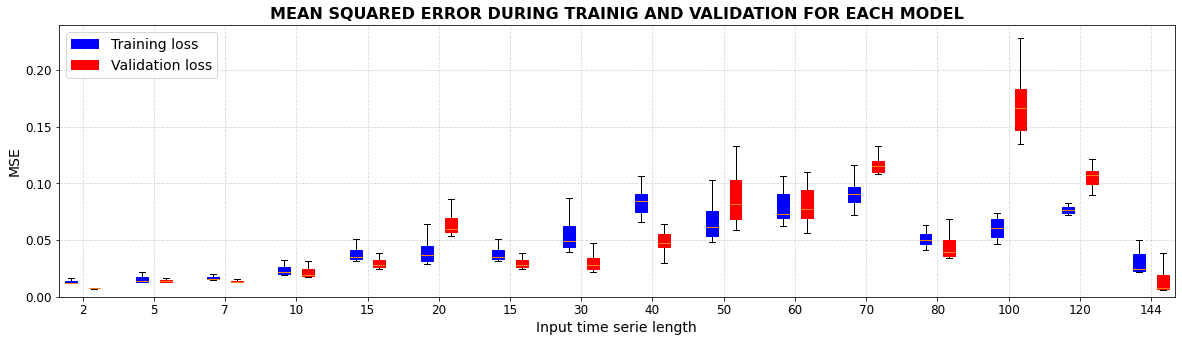

In [480]:
fig, ax = plt.subplots(figsize=(20, 5), sharey=True)

width = 0.5
s, e = 1, 2
for i, ts_length in enumerate(ts_lengths):
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    with open(f"{path_model}/HISTORY-{prefix}.pkl", 'rb') as handle:
        history = pickle.load(handle)
    bp = ax.boxplot((history['loss'], history['val_loss']), showfliers=False,
                    positions=(s, e), widths=0.5, patch_artist=True)
    s += 3
    e = s+1
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['boxes'][1], color='red')
    ax.grid(ls='--', alpha=0.5)
    
ax.set_title("MEAN SQUARED ERROR DURING TRAINIG AND VALIDATION FOR EACH MODEL", fontdict={'size': 16, 'weight': 'bold'})
ticks = np.arange(1, 16*3+1, 3)+0.5
ax.set_xticks(ticks)
ax.set_xticklabels([f"{x}" for x in ts_lengths])
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel("MSE", fontdict={'size': 14})
ax.set_xlabel("Input time serie length", fontdict={'size': 14})
ax.bar([1], [0], color='blue', label='Training loss')
ax.bar([1], [0], color='red', label='Validation loss')
ax.legend(loc='upper left', fontsize=14)

plt.savefig(
    f"{RESULT_PATH}/boxplot-history.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

The code below shows the training and validation history over the epochs.

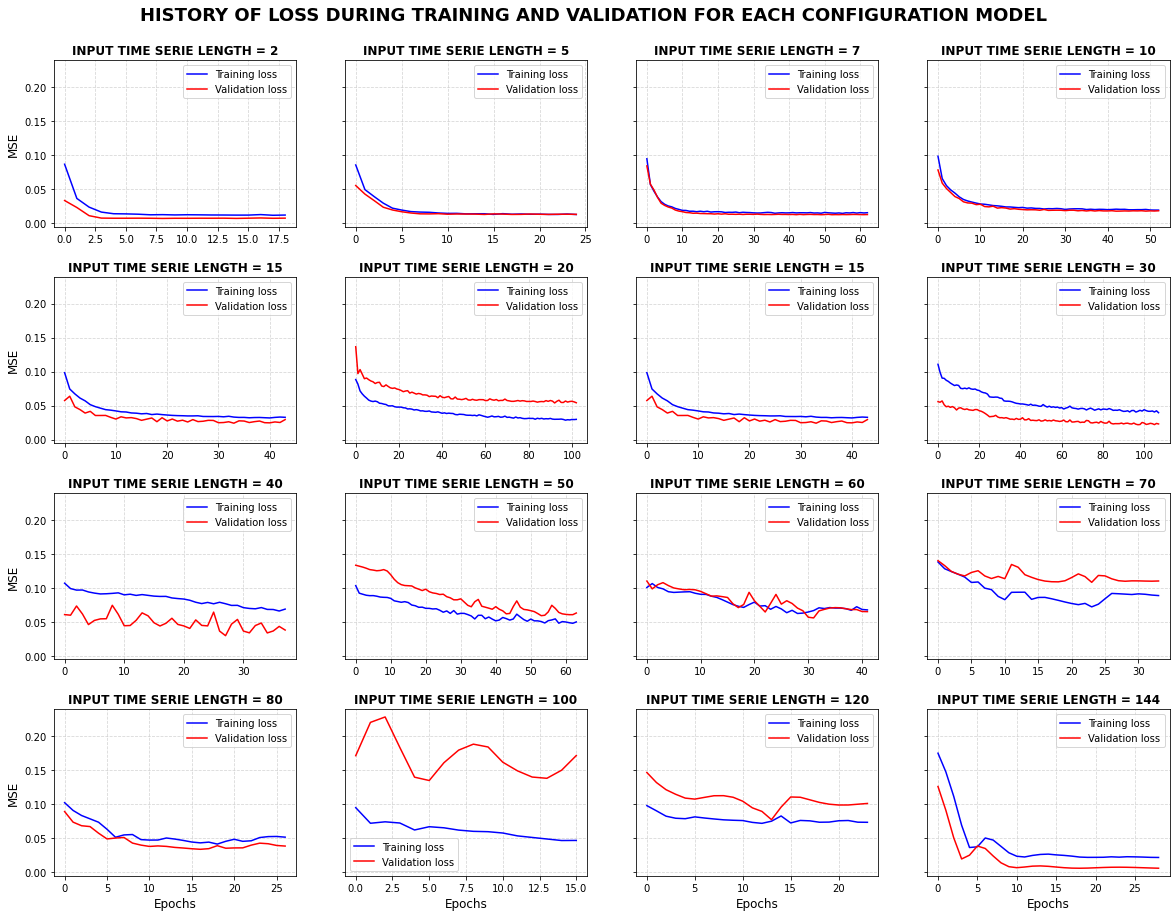

In [481]:
fig, ax = plt.subplots(4, 4, figsize=(20, 15), sharey=True)

fig.suptitle("HISTORY OF LOSS DURING TRAINING AND VALIDATION FOR EACH CONFIGURATION MODEL", y=0.93, 
             fontsize=18, fontweight='bold')
for i, ts_length in enumerate(ts_lengths):
    row = i//4
    col = i%4
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    with open(f"{path_model}/HISTORY-{prefix}.pkl", 'rb') as handle:
        history = pickle.load(handle)
        ax[row][col].set_title(f"INPUT TIME SERIE LENGTH = {ts_length-1}", fontdict={'size': 12, 'weight': 'bold'})
        ax[row][col].plot(history['loss'], color='blue', label='Training loss')
        ax[row][col].plot(history['val_loss'], color='red', label='Validation loss')
        ax[row][col].grid(ls='--', alpha=0.5)
        ax[row][col].legend()
        if row == 3:
            ax[row][col].set_xlabel("Epochs", fontdict={'size': 12})
        if col == 0:
            ax[row][col].set_ylabel("MSE", fontdict={'size': 12})
            
plt.subplots_adjust(hspace=0.3)      

plt.savefig(
    f"{RESULT_PATH}/line-history.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

#### 2.4. Scatter plot Observation vs Prediction
<hr />

Loading test data.

In [6]:
# Reading and normalizing test data
test_data = pd.read_csv(f"{DATA_PATH}/test_data.csv")

# Transforming test data
scaler = MinMaxScaler(feature_range=(-1, 1))
x_data_test = scaler.fit_transform(test_data.iloc[:, 1].values.reshape(-1, 1))

The code below compares the observed and predicted data for each model.

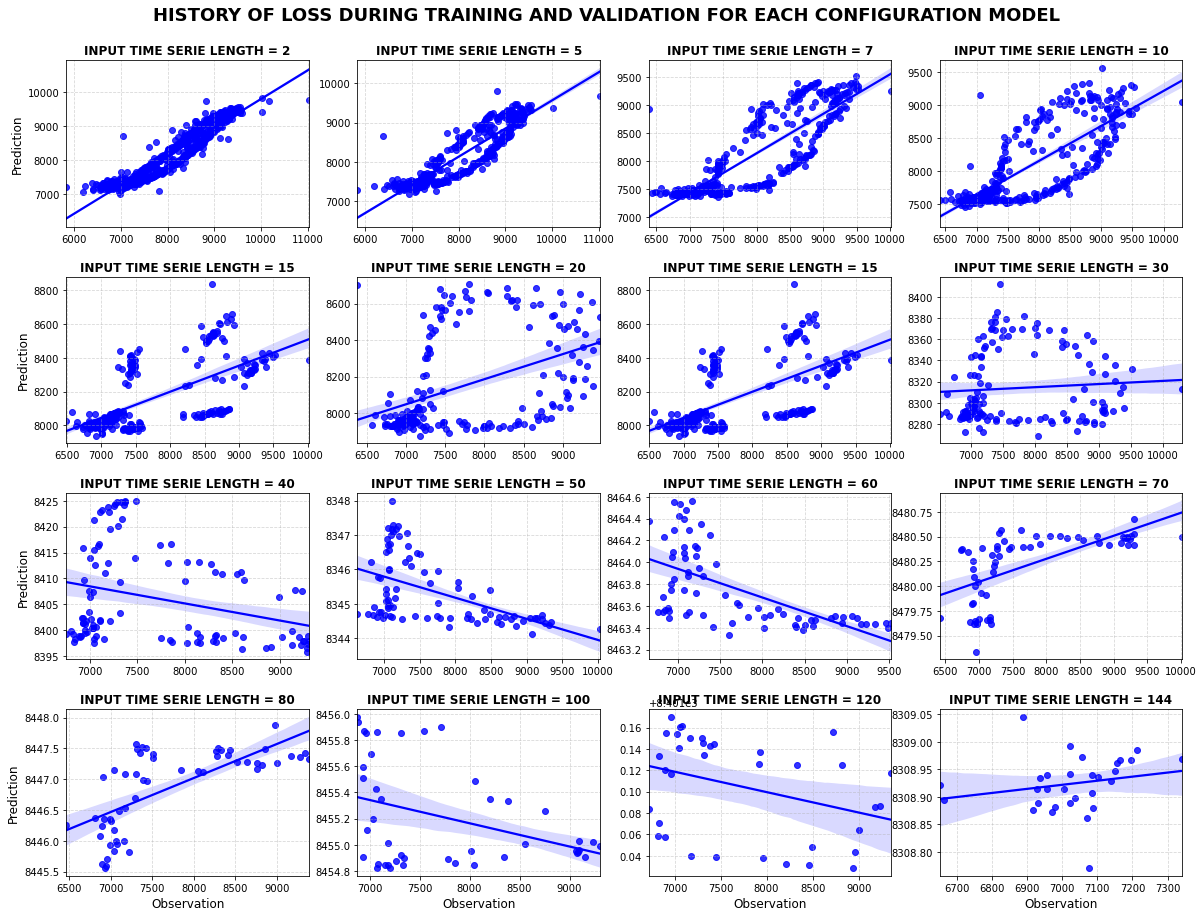

In [483]:
fig, ax = plt.subplots(4, 4, figsize=(20, 15))

fig.suptitle("HISTORY OF LOSS DURING TRAINING AND VALIDATION FOR EACH CONFIGURATION MODEL", y=0.93, 
             fontsize=18, fontweight='bold')
data_corr = []
for i, ts_length in enumerate(ts_lengths):
    row = i//4
    col = i%4
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    model = tf.keras.models.load_model(f"{path_model}/MODEL-{prefix}.hdf5")
#     scaler = MinMaxScaler(feature_range=(-1, 1))
    
    # Creating time series of test data
    X_test, y_test = create_Xy(x_data_test, ts_length, stride=stride)
    
    # Predict 
    y_pred = model.predict(X_test)[:, 0, :]
    
    true = scaler.inverse_transform(y_test)
    pred = scaler.inverse_transform(y_pred)
    data_corr.append([true, pred])
    
    ax[row][col].set_title(f"INPUT TIME SERIE LENGTH = {ts_length-1}", fontdict={'size': 12, 'weight': 'bold'})
    sns.regplot(true, pred, color='blue', ax=ax[row][col])
    
    ax[row][col].grid(ls='--', alpha=0.5)
    if row == 3:
        ax[row][col].set_xlabel("Observation", fontdict={'size': 12})
    if col == 0:
        ax[row][col].set_ylabel("Prediction", fontdict={'size': 12})

plt.subplots_adjust(hspace=0.3)   

plt.savefig(
    f"{RESULT_PATH}/scatter-comp.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

#### 2.5. Correlation analysis
<hr />

The code below generates a visuzliation of the Perason's coefficient of each model's prediction with the observation and separates those with correlation >= 0.90.

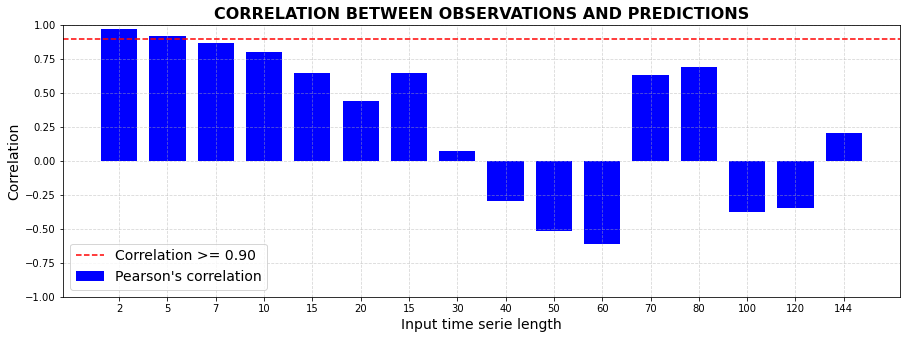

In [484]:
fig, ax = plt.subplots(figsize=(15, 5))
corrs = []
for dc in data_corr:
    corrs.append(
        np.corrcoef(dc[0][:, 0], dc[1][:, 0])[0][1]
    )

ax.set_title("CORRELATION BETWEEN OBSERVATIONS AND PREDICTIONS", fontdict={'size': 16, 'weight': 'bold'})
bars = ax.bar(np.arange(16), corrs, color='blue', width=0.75, label="Pearson\'s correlation")
ax.axhline(0.90, color='red', ls='--', label='Correlation >= 0.90')
ax.set_ylim(-1., 1.)
_ = ax.set_xticks(np.arange(16)) 
_ = ax.set_xticklabels(ts_lengths) 
ax.grid(ls='--', alpha=0.5)
ax.legend(fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)
ax.set_xlabel("Input time serie length", fontsize=14)

plt.savefig(
    f"{RESULT_PATH}/bars-correlations.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

Next, the predictions of the models with a correlation greater than 0.9 are compared with the observations.

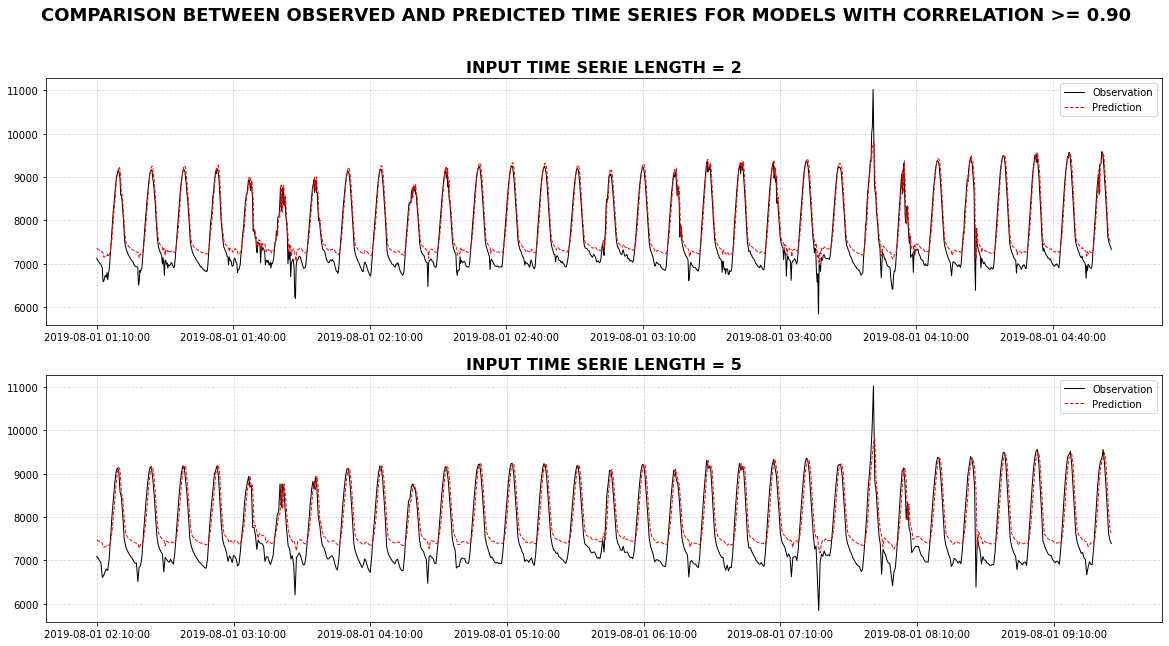

In [485]:
xticks = test_data.iloc[:, 0].values

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

fig.suptitle("COMPARISON BETWEEN OBSERVED AND PREDICTED TIME SERIES FOR MODELS WITH CORRELATION >= 0.90", 
             fontsize=18, fontweight='bold')
for i, ts_length in enumerate(ts_lengths[:2]):
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    model = tf.keras.models.load_model(f"{path_model}/MODEL-{prefix}.hdf5")
    
    # Get date times ticks for x axis
    xtick = []
    for j in range(0, len(xticks)-ts_length, stride):
        xtick.append(xticks[j+ts_length])
    
    # Creating time series of test data
    X_test, y_test = create_Xy(x_data_test, ts_length, stride=stride)
    
    # Predict 
    y_pred = model.predict(X_test)[:, 0, :]
    
    true = scaler.inverse_transform(y_test)[:, 0]
    pred = scaler.inverse_transform(y_pred)[:, 0]
    
    ax[i].set_title(f"INPUT TIME SERIE LENGTH = {ts_length-1}", fontdict={'size':16, 'weight': 'bold'})
    ax[i].plot(true, color='k', lw=1, ls='-', label='Observation')
    ax[i].plot(pred, color='red', lw=1, ls='--', label='Prediction')
    ax[i].set_xticklabels(xtick)
    ax[i].legend()
    ax[i].grid(ls='--', alpha=0.5)
    
plt.savefig(
    f"{RESULT_PATH}/comparation-models.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

#### 2.6. Dynamic time warping (DTW)
<hr />

Next, some analyzes based on Dynamic Time Warping (DTW) of the predictions of the bests models (based on threshold correlation) and observations. For this, the library [DTAIDistance] (https://dtaidistance.readthedocs.io/en/latest/index.html) was used.

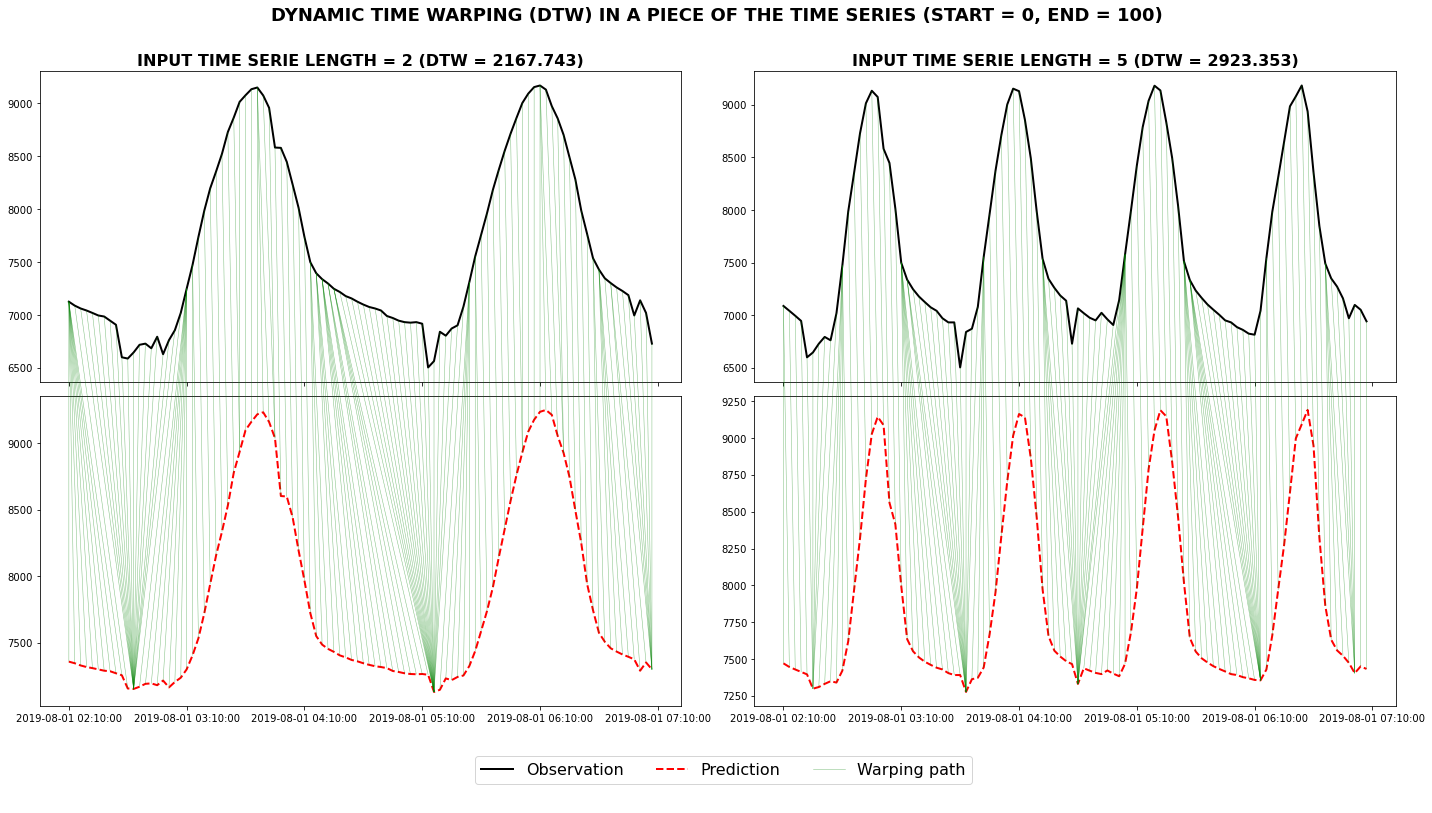

In [489]:
import matplotlib as mpl
    
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex='all')

start, end = 0, 100
fig.suptitle(f"DYNAMIC TIME WARPING (DTW) IN A PIECE OF THE TIME SERIES (START = {start}, END = {end})",
            fontsize=18, fontweight='bold', y=1.01)
for i, ts_length in enumerate(ts_lengths[:2]):
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    model = tf.keras.models.load_model(f"{path_model}/MODEL-{prefix}.hdf5")
    
    # Get date times ticks for x axis
    xtick = []
    for j in range(0, len(xticks)-ts_length, stride):
        xtick.append(xticks[j+ts_length])
    
    # Creating time series of test data
    X_test, y_test = create_Xy(x_data_test, ts_length, stride=stride)
    
    # Predict 
    y_pred = model.predict(X_test)[:, 0, :]
    
    true = scaler.inverse_transform(y_test)[:, 0]
    pred = scaler.inverse_transform(y_pred)[:, 0]
    
    s1 = true[start:end] 
    s2 = pred[start:end]
    path = dtw.warping_path(s1, s2)
    ax[0][i].set_title(f"INPUT TIME SERIE LENGTH = {ts_length-1} (DTW = {dtw.distance(s1, s2):.3f})", 
                       fontdict={'size':16, 'weight': 'bold'})
    
    ax[0][i].plot(s1, color='k', lw=2, ls='-')
    ax[1][i].plot(s2, color='red', lw=2, ls='--')
    ax[1][i].set_xticklabels(xtick[start:end])
    plt.tight_layout()
    lines = []
    for r_c, c_c in path:
        if r_c < 0 or c_c < 0:
            continue
        con = mpl.patches.ConnectionPatch(xyA=[r_c, s1[r_c]], coordsA=ax[0][i].transData,
                              xyB=[c_c, s2[c_c]], coordsB=ax[1][i].transData, color='green', lw=0.5, alpha=0.5)
        lines.append(con)

    for line in lines:
        fig.add_artist(line)
        
lax = fig.add_axes([0.03, -0.1, 0.95, 0.1])
lax.axis('off')
lax.plot([], color='k', lw=2, ls='-', label='Observation')
lax.plot([], color='red', lw=2, ls='--', label='Prediction')
lax.plot([],  color='green', lw=0.5, alpha=0.5, label='Warping path')
lax.legend(ncol=3, loc='center', fontsize=16)

plt.savefig(
    f"{RESULT_PATH}/paths-dtw.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

#### 2.7. DTW accumulated cost matrix
<hr />

Below, a visualization of one of the DTW metrics is generated, the accumulated cost matrix.

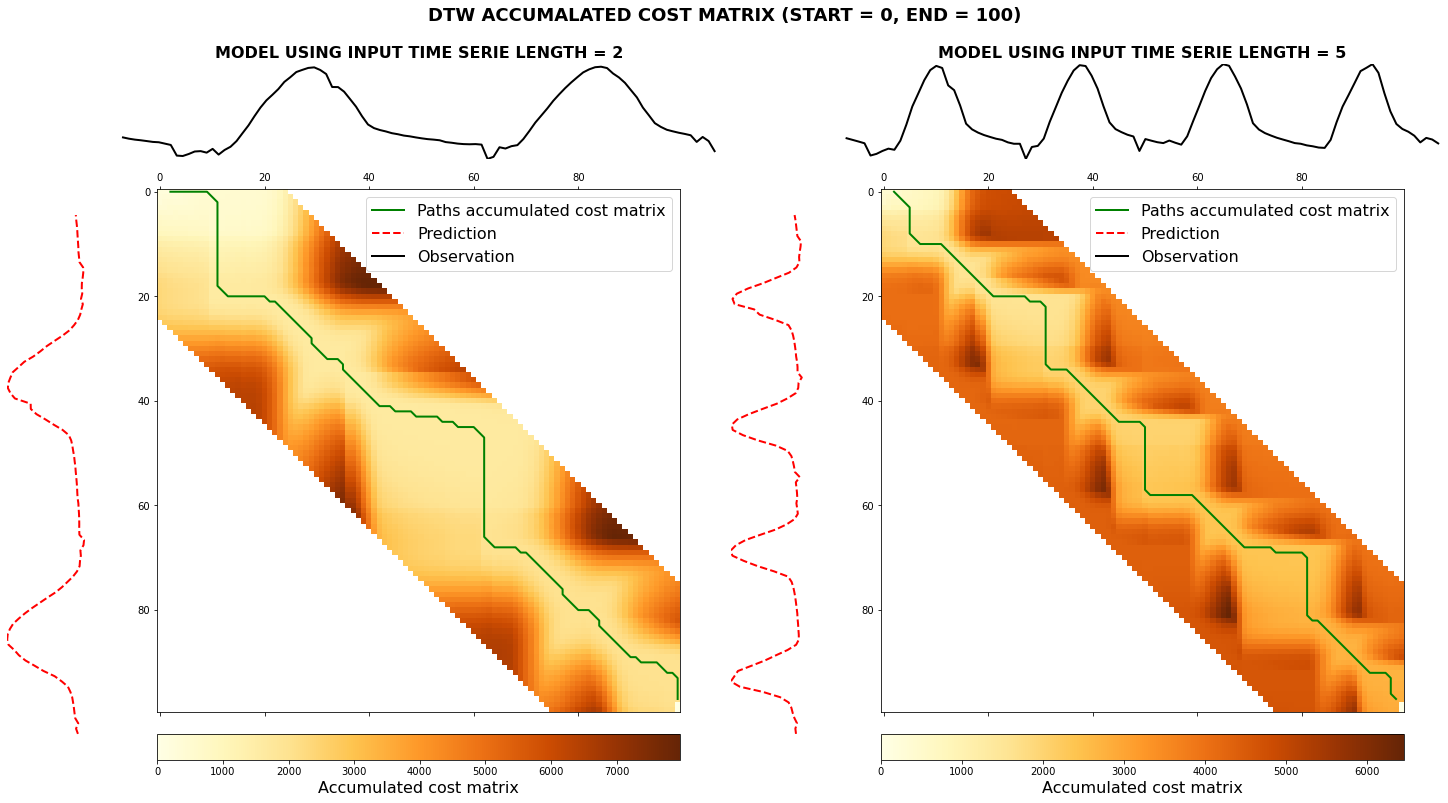

In [491]:
def get_s1s2(ts_length, start, end):
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    model = tf.keras.models.load_model(f"{path_model}/MODEL-{prefix}.hdf5")
    
    # Get date times ticks for x axis
    xtick = []
    for j in range(0, len(xticks)-ts_length, stride):
        xtick.append(xticks[j+ts_length])
    
    # Creating time series of test data
    X_test, y_test = create_Xy(x_data_test, ts_length, stride=stride)
    
    # Predict 
    y_pred = model.predict(X_test)[:, 0, :]
    
    true = scaler.inverse_transform(y_test)[:, 0]
    pred = scaler.inverse_transform(y_pred)[:, 0]
    
    return true[start:end], pred[start:end]


fig = plt.figure(constrained_layout=True, figsize=(20, 10))
fig.suptitle(f"DTW ACCUMALATED COST MATRIX (START = {start}, END = {end})", fontsize=18, fontweight='bold', y=1.05)
gs = fig.add_gridspec(2, 4, height_ratios=[1, 6], width_ratios=[1, 6, 1, 6])

# Getting attributes for model 1 plot
s1, s2 = get_s1s2(ts_lengths[0], start=start, end=end)
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
ratio = max(len(s1), len(s2))
min_y = min(np.min(s1), np.min(s2))
max_y = max(np.max(s1), np.max(s2))
max_s2_x = np.max(s2)
max_s2_y = len(s2)
max_s1_x = np.max(s1)
min_s1_x = np.min(s1)
max_s1_y = len(s1)
p = best_path
py, px = zip(*p)


ax1 = fig.add_subplot(gs[0, 1:2]) # Model 1, upper serie
ax1.set_title(f"MODEL USING INPUT TIME SERIE LENGTH = 2", fontdict={'size': 16, 'weight': 'bold'})
ax1.set_axis_off()
ax1.set_ylim([min_y, max_y])
ax1.xaxis.tick_top()
ax1.plot(range(len(s1)), s1, color='k', lw=2, ls='-')
ax1.set_xlim([-0.5, len(s2) - 0.5])
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())

ax2 = fig.add_subplot(gs[1:, 0]) # Model 1, left serie
ax2.set_axis_off()
ax2.set_xlim([-max_y, -min_y])
ax2.plot(-s2[::-1], range(max_s2_y, 0, -1)[::-1], color='red', lw=2, ls='--')
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())

ax3 = fig.add_subplot(gs[1, 1]) # Model 1, matrix
img = ax3.matshow(paths[1:, 1:], cmap='YlOrBr')
ax3.plot(px, py, color='green', lw=2, label="Paths accumulated cost matrix")
ax3.plot([], color='red', lw=2, ls='--', label='Prediction')
ax3.plot([], color='k', lw=2, ls='-', label='Observation')
ax3.legend(loc='upper right', fontsize=16)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('bottom', size='5%', pad=0.3)
cbar = fig.colorbar(img, cax=cax, orientation='horizontal')
cbar.set_label("Accumulated cost matrix", fontsize=16)


# Getting attributes for model 1 plot
s1, s2 = get_s1s2(ts_lengths[1], start=start, end=end)
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
ratio = max(len(s1), len(s2))
min_y = min(np.min(s1), np.min(s2))
max_y = max(np.max(s1), np.max(s2))
max_s2_x = np.max(s2)
max_s2_y = len(s2)
max_s1_x = np.max(s1)
min_s1_x = np.min(s1)
max_s1_y = len(s1)
p = best_path
py, px = zip(*p)

ax4 = fig.add_subplot(gs[0, 3:]) # Model 2, upper serie
ax4.set_title(f"MODEL USING INPUT TIME SERIE LENGTH = 5", fontdict={'size': 16, 'weight': 'bold'})
ax4.set_axis_off()
ax4.set_ylim([min_y, max_y])
ax4.xaxis.tick_top()
ax4.plot(range(len(s1)), s1, color='k', lw=2, ls='-')
ax4.set_xlim([-0.5, len(s2) - 0.5])
ax4.xaxis.set_major_locator(plt.NullLocator())
ax4.yaxis.set_major_locator(plt.NullLocator())

ax5 = fig.add_subplot(gs[1:, 2]) # Model 2, left serie
ax5.set_axis_off()
ax5.set_xlim([-max_y, -min_y])
ax5.plot(-s2[::-1], range(max_s2_y, 0, -1)[::-1], color='red', lw=2, ls='--')
ax5.xaxis.set_major_locator(plt.NullLocator())
ax5.yaxis.set_major_locator(plt.NullLocator())

ax6 = fig.add_subplot(gs[1, 3]) # Model 2, matrix
img = ax6.matshow(paths[1:, 1:], cmap='YlOrBr')
ax6.plot(px, py, color='green', lw=2, label="Paths accumulated cost matrix")
ax6.plot([], color='red', lw=2, ls='--', label='Prediction')
ax6.plot([], color='k', lw=2, ls='-', label='Observation')
ax6.legend(loc='upper right', fontsize=16)

divider = make_axes_locatable(ax6)
cax = divider.append_axes('bottom', size='5%', pad=0.3)
cbar = fig.colorbar(img, cax=cax, orientation='horizontal')
cbar.set_label("Accumulated cost matrix", fontsize=16)

plt.savefig(
    f"{RESULT_PATH}/paths-accumulated-cost-matrix.png", transparent=False, bbox_inches='tight', 
    pad_inches=0.1
)

#### 2.8. Identifying disturbances in the time series
<hr />

Next, a threshold difference between the predictions of the best models and the observations is used to identify possible perturbations in the time series.

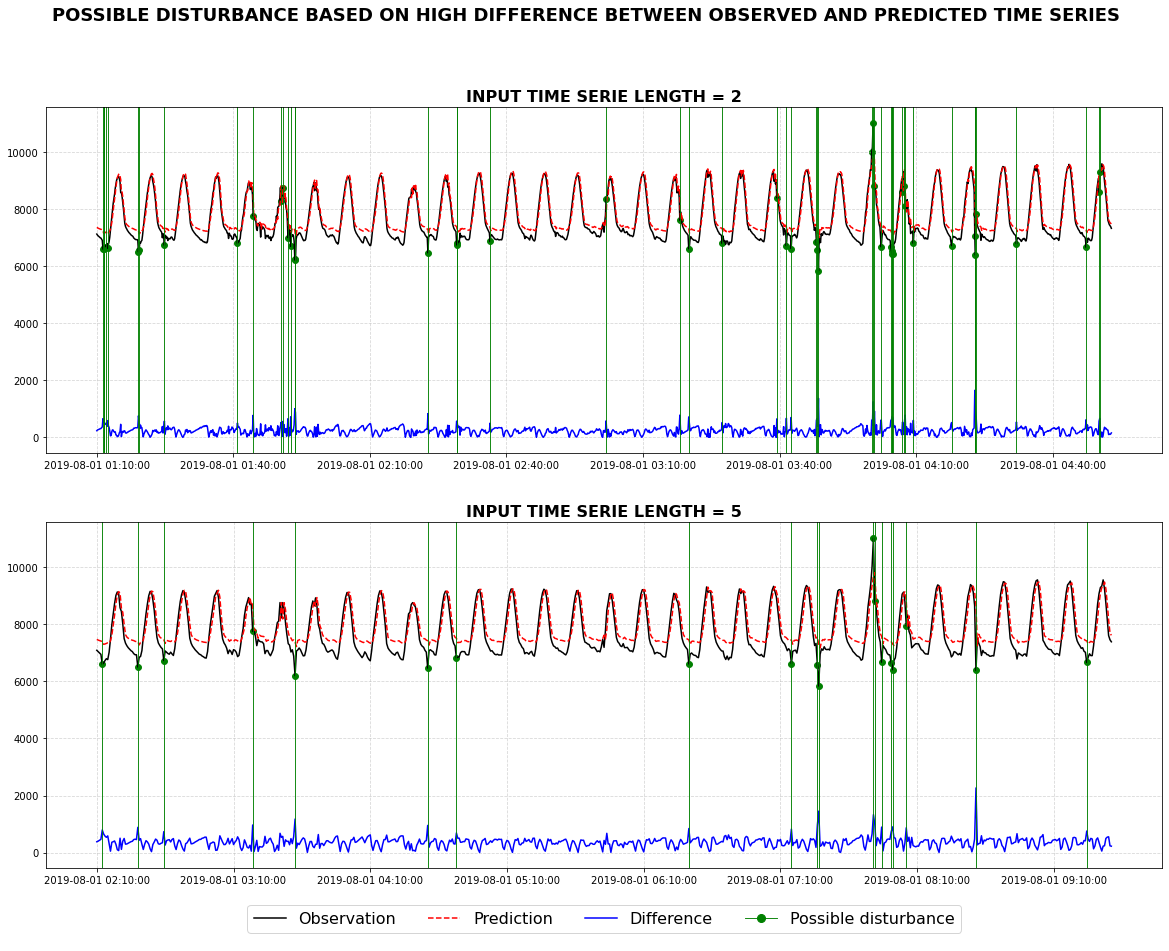

In [477]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle("POSSIBLE DISTURBANCE BASED ON HIGH DIFFERENCE BETWEEN OBSERVED AND PREDICTED TIME SERIES", 
             fontsize=18, fontweight='bold')

for i, ts_length in enumerate(ts_lengths[:2]):
    ts_length += 1
    stride = ts_length
    prefix = f"LSTM-TS{str(ts_length).zfill(3)}-ST{str(stride).zfill(3)}"
    path_model = f"{RESULT_PATH}/{prefix}"
    
    model = tf.keras.models.load_model(f"{path_model}/MODEL-{prefix}.hdf5")
    
    # Get date times ticks for x axis
    xtick = []
    for j in range(0, len(xticks)-ts_length, stride):
        xtick.append(xticks[j+ts_length])
    
    # Creating time series of test data
    X_test, y_test = create_Xy(x_data_test, ts_length, stride=stride)
    
    # Predict 
    y_pred = model.predict(X_test)[:, 0, :]
    
    true = scaler.inverse_transform(y_test)[:, 0]
    pred = scaler.inverse_transform(y_pred)[:, 0]
    
    diffs = np.abs(true-pred)
    thr = diffs.max() * 0.30
    maxv = max(true.max(), pred.max())
    
    ax[i].set_title(f"INPUT TIME SERIE LENGTH = {ts_length-1}", fontdict={'size':16, 'weight': 'bold'})
    ax[i].plot(true, color='k', label='Observation')
    ax[i].plot(pred, color='red', ls='--', label='Prediction')
    ax[i].grid(ls='--', alpha=0.5)
    ax[i].set_xticklabels(xtick)

    # ax2 = ax.twinx()
    # ax.set_axis_off()
    ax[i].plot(diffs, color='blue', label="Difference")

    for j, diff in enumerate(diffs):
        if diff > thr:
            ax[i].axvline(j, lw=0.9, color='green')
            ax[i].scatter([j], [true[j]], s=35, color='green')
    # ax2.plot([maxv if i > thr else 0 for i in diff], color='green', alpha=0.5, label="Possible disturbance")


ax2 = fig.add_axes([0.125, 0.05, 0.775, 0.05])
ax2.set_axis_off()
ax2.plot([], color='k', label='Observation')
ax2.plot([], color='red', ls='--', label='Prediction')
ax2.plot([], color='blue', label="Difference")
ax2.plot([], [], marker='o', lw=0.9, markersize=8, color='green', label="Possible disturbance")
ax2.legend(loc='center', ncol=4, fontsize=16)

### 3. References
<hr />

<li id="goodfellow_deep_2016">
Goodfellow, I., Bengio, Y. and Courville, A., 2016. Deep learning. MIT press.
</li>

<li id="dupond_thorough_2019">
Dupond, S., 2019. A thorough review on the current advance of neural network structures. Annual Reviews in Control, 14, pp.200-230.
</li>

<li id="rumelhart_learning_1986">
Rumelhart, D.E., Hinton, G.E. and Williams, R.J., 1986. Learning representations by back-propagating errors. Nature, 323(6088), pp.533-536.
</li>

<li id="hochreiter_long_1997">
Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
</li>

<li id="kawakami_supervised_2008">
Graves, A., 2012. Supervised Sequence Labelling with Recurrent Neural Networks. Studiesin Computational Intelligence.
</li>